<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/segmentationQC_trackingQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [51]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True);

Mounted at /content/drive


In [1]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

ModuleNotFoundError: No module named 'google.colab'

# Global Parameters and Setup


### General library imports

In [28]:
import numpy as np
from ipywidgets import interact, widgets, Layout
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imsave, imshow
from skimage import data, filters, measure, morphology, util
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
from pathlib import Path
from fastprogress.fastprogress import progress_bar,master_bar
import tifffile
import pandas as pd
import ntpath
import os
import time
import pickle
import re
import copy
import scipy
import shutil
import random
import sys
from scipy import ndimage
import numpy as np
from ipywidgets import interact, widgets, Layout
import matplotlib.pyplot as plt



#Get from Drive the folder libraries
# !cp -r /content/drive/MyDrive/libraries /content
import importlib
from libraries.filter_cells_fns import *
from libraries.centers import *
from libraries.qc_functions import *
import centroidtracker
importlib.reload(centroidtracker);


## Parameter Setup

### Colab Parameters

In [2]:
#@markdown where various folders are on disk, you probably never need to change these

local_folder = "content" #@param {type:"string"};
local_folder:Path = Path(local_folder);

#where files and folders are stored when downloaded from GCP
gcp_transfer_folder = "gcp_transfer" #@param {type:"string"}
gcp_transfer_folder:Path = Path(gcp_transfer_folder)

#where files and folders are stored locally that should be cleared between operations
temp_folder = "temp" #@param {type:"string"}
temp_folder:Path = Path(temp_folder)

if not os.path.exists(gcp_transfer_folder):
  os.mkdir(gcp_transfer_folder);

if not os.path.exists(temp_folder):
  os.mkdir(temp_folder);

### Experimental Parameters

In [3]:
#@markdown Experiment Name (will be incorporated into output file and folder names)
experiment = "2022.3.8 Migration Test 8" #@param {type:"string"}


#@markdown Analysis folder: all output analysis data will be output to gs://{analysis output folder}/{experiment name}
analysis_output_folder = "optotaxisbucket/Segmentation Analysis" #@param {type:"string"}
analysis_output_folder:Path = Path(analysis_output_folder)
gcp_analysis_output_folder:Path = analysis_output_folder/experiment;
local_analysis_output_folder:Path = gcp_transfer_folder/analysis_output_folder.name/experiment;
if not os.path.exists(local_analysis_output_folder):
  os.makedirs(local_analysis_output_folder);
del analysis_output_folder;

if "gcp_images" in locals():
  prev_im = gcp_images
else:
  prev_im = None;

if "gcp_cell_masks" in locals():
  prev_cm = gcp_cell_masks
else:
  prev_cm = None;

if "gcp_nuc_masks" in locals():
  prev_nm = gcp_nuc_masks
else:
  prev_nm = None;


#@markdown Location of experiment images on the GCP bucket. Can be a folder, a .zip file, or a tif stack; If a zip file, should contain a folder of the same name as the zip file. Exclude the 'gs://' from the path.
gcp_images = "optotaxisbucket/movies/2022.3.8 Migration Test 8" #@param {type:"string"}
gcp_images:Path = Path(gcp_images);

#@markdown Location of segmented cell-area masks on the GCP bukcet. Can be a folder, a .zip file, or a tif stack; If a zip file, should contain a folder of the same name as the zip file. Exclude the 'gs://' from the path.
gcp_cell_masks = "optotaxisbucket/movie_segmentation/2022.3.8 Migration Test 8/segmentation_output_masks/Cell.zip" #@param {type:"string"}
gcp_cell_masks:Path = Path(gcp_cell_masks);

#@markdown Location of segmented nucleus-area masks on the GCP bukcet. Can be a folder, a .zip file, or a tif stack; If a zip file, should contain a folder of the same name as the zip file. Exclude the 'gs://' from the path.
gcp_nuc_masks = "optotaxisbucket/movie_segmentation/2022.3.8 Migration Test 8/segmentation_output_masks/Nucleus.zip" #@param {type:"string"}
gcp_nuc_masks:Path = Path(gcp_nuc_masks);

images_changed,cell_masks_changed,nuc_masks_changed = [False,False,False];
if gcp_images != prev_im:
  images_changed = True;
if gcp_cell_masks != prev_cm:
  cell_masks_changed = True;
if gcp_nuc_masks != prev_nm:
  nuc_masks_changed = True;




#@markdown TODO: add input validation (check if paths exist in GCP)

## Global helper function setup

### File Management

In [4]:
#keyword should be unique for each type of object pulled from the cloud to avoid collisions
def _fetch_image_files(in_path:Path,keyword:str,overwrite:bool)->Path: ##should not be called outside of other helper functions, will always overwrite
  # print(in_path);
  is_file = str(in_path).lower().endswith(('.zip','.tif','.tiff'));
  destination = gcp_transfer_folder/keyword/experiment;
  if not(os.path.exists(destination)):
    os.makedirs(destination);
  # copy_out = Path(destination)/in_path.name;
  command_output = None;
  if overwrite or len(os.listdir(destination)) == 0:
    if is_file:
      command_output = !gsutil -m cp -r "gs://{in_path}" "{destination}"
    else:
      command_output = !gsutil -m cp -r "gs://{in_path}/**" "{destination}"
  if (command_output is not None and command_output[0].startswith("CommandException")):
    raise RuntimeError(f"Error while downloading {keyword} from bucket: " + command_output[0]);
  elif len(os.listdir(destination)) == 0:
    raise RuntimeError("Error: downloading failed for an unknown reason");
  # print(in_path.suffix);
  if (not is_file):
    return destination; #we're done
  else:
    destination = destination/in_path.name;
  if (in_path.suffix == '.zip'):
    out_path = destination.with_suffix('');
    # print(copy_out);
    command_output = None;
    if (overwrite or not os.path.exists(out_path)):
      command_output = !unzip -o "{destination}" -d "{destination.parent}"
    # print(command_output);
    if (command_output is not None and command_output[0].startswith("CommandException")):
      raise RuntimeError(f"Error while unzipping {keyword}: " + command_output[0]);
    elif not os.path.exists(out_path):
      raise RuntimeError(f"Error: zip file {destination} does not contain folder {destination.with_suffix('')}");
    return out_path;
  elif (in_path.suffix.lower().startswith('.tif')):
    raise NotImplementedError("unstacking TIF files not yet supported");
  else:
    raise NameError("Invalid input suffix, input validation should have caught this >:(");  

In [5]:
def fetch_images(force_overwrite=False)->Path:
  global images_changed;
  out = _fetch_image_files(Path(gcp_images),'images',images_changed or force_overwrite);
  images_changed = False;
  return out;

def fetch_cell_masks(force_overwrite=False)->Path:
  global cell_masks_changed;
  out = _fetch_image_files(Path(gcp_cell_masks),'cellmasks',cell_masks_changed or force_overwrite);
  cell_masks_changed = False;
  return out;

def fetch_nuc_masks(force_overwrite=False)->Path:
  global nuc_masks_changed;
  out = _fetch_image_files(Path(gcp_nuc_masks),'nucmasks',nuc_masks_changed or force_overwrite);
  nuc_masks_changed = False;
  return out;

In [14]:
def push_analysis(): #VERY IMPORTANT: THIS METHOD RELIES ON local_analysis_output_folder BEING ONE-DEPTH
  s = !gsutil -m cp "{local_analysis_output_folder}/*" "gs://{gcp_analysis_output_folder}"
  if (s[0].startswith("CommandException")):
    raise RuntimeError("error while uploading analysis folder: " + s[0]);

def fetch_analysis():
  if not os.path.exists(local_analysis_output_folder):
    os.makedirs(local_analysis_output_folder);
  s = !gsutil -m cp -r -n "gs://{gcp_analysis_output_folder}/*" "{local_analysis_output_folder}"
  if (s[0].startswith("CommandException")):
    raise RuntimeError("error while downloading analysis folder: " + s[0]);
  

# fetch_analysis();

In [7]:
def on_rm_error( func, path, exc_info):
    # path contains the path of the file that couldn't be removed
    # let's just assume that it's read-only and unlink it.
    os.chmod( path, stat.S_IWRITE )
    # os.unlink( path )

def cleardir(dir): #clears all files in dir without deleting dir
  for f in os.scandir(dir):
    # f = os.path.join(dir,f)
    if os.path.isdir(f): shutil.rmtree(f,onerror=on_rm_error); #just in case
    else: os.remove(f);

### Cell filtering

In [8]:
def getcells(filecell,filenuc,parameters,return_metrics):
  #membrane
  maskMem=imread(filecell)
  # print(np.min(maskmem));
  # print(np.max(maskmem));
  maskMem[maskMem>0]=1
  #fill holes
  maskMem=ndimage.binary_fill_holes(maskMem).astype(int);

  #nuclei
  maskNuc = imread(filenuc)
  maskNuc[maskNuc>0]=1

  #label different objectes in masks
  maskMem,numMem = measure.label(maskMem,return_num=True)
  maskNuc,numNuc = measure.label(maskNuc,return_num=True);

  if numMem < 255 and numNuc < 255:
    maskMem = maskMem.astype('uint8');
    maskNuc = maskNuc.astype('uint8');
  else:
    maskMem = maskMem.astype('uint16');
    maskNuc = maskNuc.astype('uint16');
  
  #FILTERS
  if parameters['remove_cells_touching_edge'] == True:
    maskmem=remove_touching_edge(maskMem)
  
  if parameters['filter_cell_size'] == True:
    maskMem = morphology.remove_small_objects(maskMem, parameters['minareacell'],in_place=True)       
    maskMem = remove_large_objects(maskMem, parameters['maxareacell'])
  
  if parameters['filter_nuc_size'] == True:
    maskNuc = morphology.remove_small_objects(maskNuc, parameters['minareanuc'],in_place=True)       
  
  if parameters['remove_multi_nuclei_cells'] == True:
    maskMem = remove_multiple_nuclei_cells(maskMem,maskNuc)

  if (return_metrics):
    #if there are cells get metrics
    ids=list(range(1,numMem+1));
    #remove 0 (background) from ids
    # ids.remove(0)
    if len(ids) > 0:
      cellsmetrics = measure.regionprops_table(maskMem, properties=('label','area'))
      cellsmetrics=pd.DataFrame(cellsmetrics)

      #GET CENTERS
      #get labels
      labels=cellsmetrics['label']    
      #Because 'label' was copied from the table, after computing the centers 
      #and concatenating them to the table they should be in the right order
      centers=get_centers(maskMem,'approximate-medoid',labels, False)
      #add centers to cell properties
      appmedoid=pd.DataFrame(data=np.asarray(centers),columns=['approximate-medoidx','approximate-medoidy'])
      cellsmetrics=pd.concat([cellsmetrics,appmedoid],1)
      
      centers=get_centers(maskMem,'centroid',labels, False)
      #add centers to cell properties
      centroid=pd.DataFrame(data=np.asarray(centers),columns=['centroidx','centroidy'])
      cellsmetrics=pd.concat([cellsmetrics,centroid],1)
      
      #centers=get_centers(maskl,'largest-circle',labels, False)
      ##add centers to cell properties
      #largecircle=pd.DataFrame(data=np.asarray(centers),columns=['largecirclex','largecircley'])
      #cellsmetrics=pd.concat([cellsmetrics,largecircle],1)

    else:
      cellsmetrics=[]
    return cellsmetrics, maskMem, maskNuc 
  else:
    return maskMem,maskNuc
 

# Segmentation quality control

### Copy data from GCP to Colab

In [ ]:
folderimages = fetch_images();
foldermasks = fetch_cell_masks(True);
foldernucmasks = fetch_nuc_masks(True);

In [ ]:
print(folderimages);
print(foldermasks);
print(foldernucmasks);

gcp_transfer/images/2022.3.8 Migration Test 8
gcp_transfer/cellmasks/2022.3.8 Migration Test 8/Cell
gcp_transfer/nucmasks/2022.3.8 Migration Test 8/Nucleus


### Set contrast

#### Look at the histogram of intensity of some images

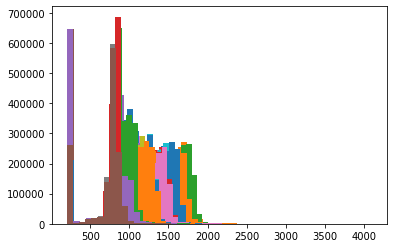

In [ ]:
#Get name of images (end with .TIF)
imagenames=[f for f in os.listdir(folderimages) if f.endswith('.TIF')]
#Plot some pixel histograms
for i in range(0,len(imagenames),100):
  image=imread(folderimages/imagenames[i])
  plt.hist(image.ravel(),50)

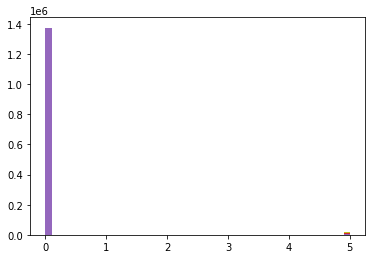

In [ ]:
#Histogram of masks, the peaks are background, membrane, nuclei
#from segmentation step masks should have the same names as images
imagenames=[f for f in os.listdir(foldermasks) if f.endswith('.TIF')]
for i in range(0,len(imagenames),100):
  image=imread(foldermasks/imagenames[i])
  plt.hist(image.ravel(),50)

#### Set bounds of intensity

In [ ]:
minintensity=500 #@param {type:"integer"}
maxintensity=2000 #@param {type:"integer"}

### Find number of frames per movie and image basename

In [ ]:
#imagenames=[f for f in os.listdir(folderimages) if f.endswith('.TIF')]
imagenames=[f for f in os.listdir(foldermasks) if f.endswith('.TIF')]
#Get list of movies
movies = [int(re.findall(r"s(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
#get set of unique elements
movies = list(set(movies))
#sort
movies.sort()
nmovies=len(movies)
print("movies detected in experiment:",movies);
#Get frame numbers and show the largest number
listframes=[int(re.findall(r"t(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
nframes=max(listframes)
print("frames detected per movie:",nframes);
# imagenames[0]
basename= re.findall(r"(.*)_s",imagenames[0])[0]
print("image basename:",basename);



movies detected in experiment: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
frames detected per movie: 283
image basename: p


### Load separate cell masks and nucleus masks and visualize together

In [ ]:
#@markdown ### Input and save cell filtering parameters

remove_cells_touching_edge = True #@param {type:"boolean"}

remove_multi_nuclei_cells = True #@param {type:"boolean"}

#@markdown #### Size bounds (number of pixels)



filter_cell_size = True #@param {type:"boolean"}

pixelsize_um=1 #@param {type:"number"}
#minarea=600
#maxarea=3200
#nucminarea=21*pixelsize**2

minareacell=250 #@param {type:"integer"}
maxareacell=15000 #@param {type:"integer"}

filter_nuc_size = False #@param {type:"boolean"}
minareanuc=5 #@param {type:"integer"}

reading_cells_parameters = {
    'experiment':experiment, 
    'basename':basename,
    'nmovies':nmovies,
    'nframes':nframes,
    'remove_cells_touching_edge':remove_cells_touching_edge,
    'remove_multi_nuclei_cells':remove_multi_nuclei_cells,
    'pixelsize_um':pixelsize_um,
    'filter_cell_size':filter_cell_size,
    'minareacell':minareacell,
    'maxareacell':maxareacell,
    'filter_nuc_size':filter_nuc_size,
    'minareanuc':minareanuc
              }

if not os.path.exists(local_analysis_output_folder):
  os.makedirs(local_analysis_output_folder)

with open(local_analysis_output_folder/'reading_cells_parameters.pkl', 'wb') as handle:
    pickle.dump(reading_cells_parameters, handle)

In [ ]:
# %%capture

#@markdown Which movie to view
movie=11 #@param {type:"integer"}

#@markdown Frame downsample rate (how often a frame is shown); increase this number for a faster processing time but less fine time-control
frspace=1 #@param {type:"integer"}

#@markdown Nucleus intensity for combined image (between 0 and 1)
mfrac=0.7 #@param {type:"number"}

#@markdown how much to resize the image by (the more downscaled, the faster the playing but the less the resolution)
downfrac = 0.50 #@param {type:"number"};

frames=range(1,nframes+1,frspace) #don't look at every frame for QC
combineds=[]
for i in progress_bar(frames):
    filename = basename + "_s" + str(movie)+"_t"+str(i)+".TIF";

    cell_path = foldermasks/filename;
    nuc_path = foldernucmasks/filename;

    maskmem,masknuc = getcells(cell_path,nuc_path,reading_cells_parameters,False);
    
    #masks.append(mask)
    #read image
    imageorig = imread(folderimages/filename)
    #rescale image intensity
    image = rescale_intensity(imageorig,(minintensity,maxintensity))            
    #rescale image
    image=resize(image, (image.shape[0] * 0.25 , image.shape[1] * 0.25),  anti_aliasing=True)
    #combine transparently mask and image
    
    # print(maskmem);
    #unlabel for visualization
    maskmem[maskmem>0]=1
    masknuc[masknuc>0]=1
    maskmem = rescale_intensity(maskmem.astype(image.dtype));
    masknuc = rescale_intensity(masknuc.astype(image.dtype));

    maskcomb= (maskmem - mfrac*masknuc)
    maskcomb[maskcomb<0]=0; #this is so stupid

    maskcomb=resize(maskcomb,(int(maskcomb.shape[0]*0.25), int(maskcomb.shape[1]*0.25)),  anti_aliasing=True )

    combined=np.hstack((image,maskcomb))

    combineds.append(combined)



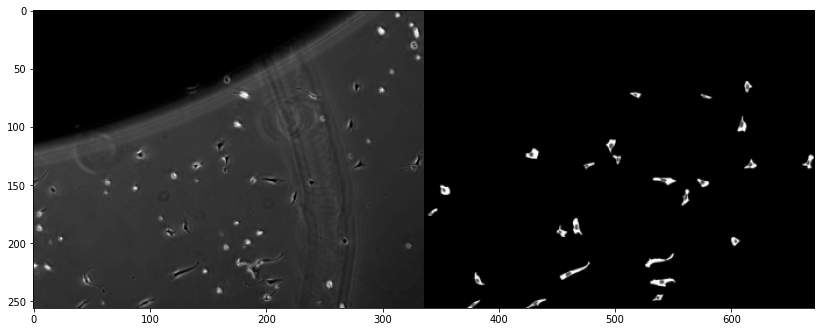

In [ ]:
def f(frame):
    print("displaying",frame);
    l.set_data(combineds[frame-1])
    fig.canvas.draw() #use with %matplotlib notebook
    display(fig) #use with %matplotlib inline
    # plt.imshow(img_median, cmap="gray") #This would work
    #plt.show()

fig = plt.figure(figsize=(14, 8))
ax_mask = fig.add_subplot(111) 
l = ax_mask.imshow(combineds[0], cmap="gray")

In [ ]:
interact(f, frame=widgets.IntSlider(min=1,max=len(combineds),step=1,value=1,msg_throttle=1,layout=Layout(width='90%', height='40px'))) 

In [ ]:
#@markdown ##Play movie
import time
import ipywidgets
#@markdown how quickly movie will be shown in frames per second (will be limited by image display speed)
framerate =  2#@param {"type":"number"}
delay = 1/framerate;





play = widgets.Play(
    value=0,
    min=0,
    max=len(combineds)-1,
    step=1,
    interval=delay*1000,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider()
widgets.jslink((play, 'value'), (slider, 'value'))
display(widgets.HBox([play, slider]))

interact(f,frame=slider);




interactive(children=(IntSlider(value=0, description='frame'), Output()), _dom_classes=('widget-interact',))

### Save Cell Filtering Parameters and Upload

In [ ]:
push_analysis();

### Save Movie as .tiff stack

In [ ]:
#@markdown Where to save the output movie file in the GCP bucket (exclude the gs://);
gcp_movie_path =  f"optotaxisbucket/QC_movies/{experiment}-s{movie}.tiff" #@param 
gcp_movie_path = Path(gcp_movie_path);
# if not str(gcp_movie_path).lower().endswith((".tif",".tiff")):
#   gcp_movie_path = gcp_movie_path.with_suffix(".tiff");
cleardir(temp_folder);
local_output = temp_folder/gcp_movie_path.name;

with tifffile.TiffWriter(local_output) as stack:
    for im in combineds: #case 
        stack.save(
            im,
            photometric='minisblack', 
            contiguous=True
        )

!gsutil -m cp "{local_output}" "gs://{gcp_movie_path}"

Copying file://temp/2022.3.8 Migration Test 8-s11.tiff [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/371.5 MiB.                                    


# Get cell features (table), labeled masks, and track

### Clear temporary directory for use

In [9]:
cleardir(temp_folder);

### Fetch and process cell and nucleus masks

In [ ]:
folder_incell = fetch_cell_masks();
folder_innuc = fetch_nuc_masks();

folder_cellmasks = temp_folder/"cellmasks";
folder_nucmasks = temp_folder/"nucmasks";
if not os.path.exists(folder_cellmasks):
  os.makedirs(folder_cellmasks);
if not os.path.exists(folder_nucmasks):
  os.makedirs(folder_nucmasks);

#get cell_nuc_masks names
masknames=[f for f in os.listdir(folder_incell) if f.endswith('.TIF')]

In [ ]:
#Edit masks so that they contain only zeroes (backgroud) and ones (objects) 
print("extracting masks...");
for maskname in progress_bar(masknames):
  maskcell=imread(folder_incell/maskname)
  #Get mask of only cell membrane
  maskcell[maskcell != 0] = 1
  #fill holes
  maskcell=ndimage.binary_fill_holes(maskcell)
  imsave((folder_cellmasks/maskname).with_suffix('.png'), util.img_as_ubyte(maskcell),check_contrast=False,plugin='pil',optimize=True,bits=1); #use pil to use less space in temp files

  #Get mask of only nucleus
  masknuc=imread(folder_innuc/maskname)
  masknuc[masknuc != 0] = 1
  imsave((folder_nucmasks/maskname).with_suffix('.png'), util.img_as_ubyte(util.img_as_bool(masknuc)),check_contrast=False,plugin='pil',optimize=True,bits=1);


extracting masks...


In [ ]:
masknames[0]

'p_s11_t97.TIF'

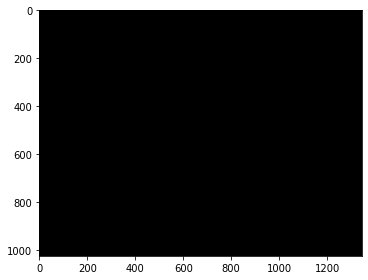

In [ ]:
imshow(imread((folder_nucmasks/masknames[0]).with_suffix('.png')));

### Fetch Cell Reading & Filtering Parameters (if this step fails, make sure filters have been set in Segmentation Quality Control)

In [16]:
fetch_analysis();

with open(local_analysis_output_folder/"reading_cells_parameters.pkl",'rb') as f:
  reading_cells_parameters = pickle.load(f);
pixelsize_um = reading_cells_parameters['pixelsize_um'];

In [ ]:
#Get list of movies
movies = [int(re.findall("s(\d+).", masknames[i])[0]) for i in range(len(masknames)) ]
#get set of unique elements
movies = list(set(movies))
#sort
movies.sort()
nmovies=len(movies)
print("movies detected in experiment:",movies);
#Get frame numbers and show the largest number
listframes=[int(re.findall("t(\d+).", masknames[i])[0]) for i in range(len(masknames)) ]
nframes=max(listframes)
frames=range(1,nframes+1)
print("frames detected per movie:",nframes);

masknames[0]
basename= re.findall("(.*)_s",masknames[0])[0]
print("image basename:",basename);

if (nmovies != reading_cells_parameters['nmovies'] or nframes != reading_cells_parameters['nframes'] or basename != reading_cells_parameters['basename']):
  raise RuntimeError("Loaded cell reading parameters do not match downloaded movies, please check file integrity");

movies detected in experiment: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
frames detected per movie: 283
image basename: p


### Input filters and get cell shape features applying filters (cell size, remove multi nuclei cells). Get labeled masks. Save data in analysis_output_folder and transfer to GCP bucket (hidden code) This step can take ~ 3 min per movie

In [ ]:
if not os.path.exists(local_analysis_output_folder):
  os.makedirs(local_analysis_output_folder)

#SAVE LABELED MASK SO THAT FEATURES CAN BE EXTRACTED AFTER TRACKING
folder_maskscell_labeled = temp_folder/'labeledmasks' 
if not os.path.exists(folder_maskscell_labeled):
  os.mkdir(folder_maskscell_labeled);

#not necessary to specify columns, but this way 'movie' and 'frame' will be at the beginning of the cells data frame
cellmetrics=pd.DataFrame(columns=['movie','frame'])
m = master_bar(movies)
fails = [];
for s in m:
  if s not in fails:
    for fr in progress_bar(frames,parent=m):
        filename = folder_cellmasks/(basename + "_s" + str(s)+'_t'+str(fr)+'.png');
        filenamenuc = folder_nucmasks/(basename + "_s" + str(s)+'_t'+str(fr)+'.png');
        
        #get cell features in a mask and the labeled mask
        try:
          metricsmaskcells, maskcellslab,_ = getcells(filename,filenamenuc,reading_cells_parameters,True);
        except Exception as e:
          print(f"Movie Failed: {s} on frame {fr}")
          fails.append(s);
          print(e);
          break;

        #SAVE LABELED MASK SO THAT FEATURES CAN BE EXTRACTED AFTER TRACKING
        imsave(folder_maskscell_labeled/(basename + "_s" + str(s)+'_t'+str(fr)+'.TIF') , maskcellslab,check_contrast=False);
        if len(metricsmaskcells) > 0:
          #Add columns corresponding to movie and frame
          #currcells['experiment']=experiment
          metricsmaskcells['movie']=s
          metricsmaskcells['frame']=fr
          #adds metricsmaskcells below cells
          cellmetrics=cellmetrics.append(metricsmaskcells, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


Movie Failed: 14 on frame 221
No such file: '/content/temp/cellmasks/p_s14_t221.png'


In [ ]:
local_analysis_output_folder

PosixPath('gcp_transfer/Segmentation Analysis/2022.3.8 Migration Test 8')

In [ ]:
!zip -r "{local_analysis_output_folder/folder_maskscell_labeled.name}.zip" "{folder_maskscell_labeled}"

cellmetrics.to_csv(local_analysis_output_folder/'cell_features.csv')

push_analysis();

updating: temp/labeledmasks/ (stored 0%)
updating: temp/labeledmasks/p_s1_t70.TIF (deflated 100%)
updating: temp/labeledmasks/p_s9_t10.TIF (deflated 99%)
updating: temp/labeledmasks/p_s12_t270.TIF (deflated 99%)
updating: temp/labeledmasks/p_s10_t21.TIF (deflated 99%)
updating: temp/labeledmasks/p_s3_t84.TIF (deflated 100%)
updating: temp/labeledmasks/p_s7_t117.TIF (deflated 99%)
updating: temp/labeledmasks/p_s5_t254.TIF (deflated 100%)
updating: temp/labeledmasks/p_s14_t98.TIF (deflated 100%)
updating: temp/labeledmasks/p_s11_t177.TIF (deflated 99%)
updating: temp/labeledmasks/p_s4_t44.TIF (deflated 100%)
updating: temp/labeledmasks/p_s7_t100.TIF (deflated 99%)
updating: temp/labeledmasks/p_s14_t190.TIF (deflated 100%)
updating: temp/labeledmasks/p_s15_t147.TIF (deflated 99%)
updating: temp/labeledmasks/p_s9_t262.TIF (deflated 99%)
updating: temp/labeledmasks/p_s8_t220.TIF (deflated 100%)
updating: temp/labeledmasks/p_s1_t200.TIF (deflated 100%)
updating: temp/labeledmasks/p_s14_t26.T

In [ ]:
cellmetrics.iloc[0:10]

,movie,frame,label,area,approximate-medoidx,approximate-medoidy,centroidx,centroidy
0,1,1,1.0,520.0,1111.0,262.0,1111.811538,261.957692
1,1,1,5.0,413.0,730.0,290.0,728.881356,290.598063
2,1,1,6.0,257.0,968.0,297.0,968.684825,296.719844
3,1,1,7.0,833.0,1094.0,400.0,1094.130852,398.432173
4,1,1,9.0,734.0,642.0,461.0,642.664850,461.856948
5,1,1,10.0,977.0,376.0,496.0,374.405322,495.145343
6,1,1,11.0,728.0,1324.0,523.0,1323.528846,521.373626
7,1,1,12.0,384.0,665.0,509.0,664.250000,510.843750
8,1,1,13.0,618.0,1125.0,534.0,1124.205502,532.467638
9,1,1,14.0,346.0,564.0,532.0,565.661850,532.942197


In [ ]:
len(cellmetrics)

195093

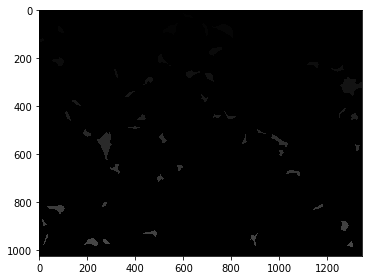

In [ ]:
m = random.choice(masknames)
imshow(imread(folder_maskscell_labeled/m))

## Input tracking parameters and track 

Reads cell_features from folder_output in GCP bucket, writes tracking_parameters and tracks to folder_output in GCP bucket

 can be either "centroid" or "approximate-medoid"

maxdist is the maximum distance in pixels allowed for a cell jump

dfracsize is the maximum fractional change in area allowed

The output (tracks) should be a file in the output folder ending with "tracks.pkl" containing a list of tables (each table is a track)

In [ ]:
fetch_analysis();

In [29]:
# %%time
#@markdown which center type (centroid or medoid) to use for tracking
centroidtype = 'approximate-medoid' #@param ["approximate-medoid","centroid"]
#@markdown maximum jump size allowed in um
maxdist_um =  200#@param {type:"integer"}
#@markdown maximum fractional area change 
dfracsize=10000 #@param {type:"number"}
#@markdown maximum frames the tracker will remember a cell's position when not in frame before it gets deleted
max_track_disappeared_time = 15 #@param {type:"integer"};
#@markdown maximum average distance an untracked cell can move per frame while still being snapped back to nearest previous position
max_untracked_speed_um = 200#@param {type:"integer"}

maxdistpixels = maxdist_um/pixelsize_um
# maxdist2=maxdistpixels**2 ##why was it squared?

max_untracked_speed_pixels = max_untracked_speed_um/pixelsize_um;

trackinging_parameters={
    'centroidtype':centroidtype, 
    'maxdist':maxdist_um, 
    'dfracsize':dfracsize,
    'maxdisappearedtime':max_track_disappeared_time,
    'maxdisappearedspeed':max_untracked_speed_pixels};

with open(local_analysis_output_folder/'tracking_parameters.pkl', 'wb') as handle:
    pickle.dump(trackinging_parameters, handle)

#This specify the cell metrics tracking is going to use
fields = ['label','movie','frame',centroidtype+'x',centroidtype+'y','area']

#copy cell shape features from bucket to colab
push_analysis();

movies = list(range(reading_cells_parameters['nmovies']))
frames = range(1,reading_cells_parameters['nframes']+1)


#read cell shape features as data frame
sample_cells:pd.DataFrame = pd.read_csv(local_analysis_output_folder/'cell_features.csv', usecols=fields)

sample=[]
to_use = [m for m in movies if m not in fails] if 'fails' in locals() else movies;
m = master_bar(to_use);

def cell_distance(t0:pd.DataFrame,t1:pd.DataFrame)->float:
    print(t0,t1);
    print(type(t0),type(t1));
    return (t0[centroidtype+'x']-t1[centroidtype+'x'])**2 + (t0[centroidtype+'y']-t1[centroidtype+'y'])**2;

def cells_filter(t0:pd.DataFrame,t1:pd.DataFrame,disappeared_time:int,dist:float)->bool:
    good_area:bool = t1['area'] > t0['area']*(1-dfracsize) and t1['area'] < t0['area']*(1+dfracsize);
    if not(good_area):
        return False;
    if disappeared_time == 0:
        return dist < maxdistpixels;
    else:
        return dist < max_untracked_speed_pixels*disappeared_time;

# def dum

for s in m:
    print(f"tracking movie {s}");
    tracks={}; #objectid, DataFrame
    # activetr=[] #contains indices of active tracks    
    tracker = centroidtracker.CentroidTracker[pd.DataFrame](
        max_track_disappeared_time,
        distance_key=cell_distance,
        frame_filter=cells_filter)
    print(tracker.distance_key);
    for fr in progress_bar(frames,parent=m):
        #get cells in current frame
        maskcells:pd.DataFrame = sample_cells[(sample_cells['movie']==s) & (sample_cells['frame']==fr)]

        cells = [maskcells.iloc[[i]] for i in range(len(maskcells))];
        print(cells[0].shape);
        print(tracker.distance_key);
        objects = tracker.update(cells);
        # print(objects.items()[0]);
        for id,frame in objects.items():
            print(frame);
            if id in tracks:
              tracks[id] = tracks[id].append(frame,ignore_index=True);
            else:
              tracks[id] = frame;

    
    sample.append(tracks)


with open(local_analysis_output_folder/'tracks.pkl', 'wb') as handle:
    pickle.dump(sample, handle)

#transfer tracks and tracking parameters to folder_output in GCP bucket
push_analysis();



tracking movie 0
<function cell_distance at 0x000002516AFF15A0>


IndexError: list index out of range

# Tracking quality control

### Get folder_output from GCP bucket. Read tracks and cell shape features (center will be used for display)

In [ ]:
s = fetch_analysis();
if any(t.startswith("CommandException") for t in s):
  print('\n'.join(s));
  raise RuntimeError();


sample_cells_metrics = pd.read_csv(local_analysis_output_folder/'cell_features.csv')

with open(local_analysis_output_folder/'tracks.pkl', 'rb') as handle:
            tracks = pickle.load(handle, encoding='latin1')

### Copy images and masks from GCP to colab. 

In [ ]:
import time
sttime = time.time()
folderimages = fetch_images();
foldermasks = fetch_cell_masks();
entime = time.time()
print("time taken:",entime-sttime);

time taken: 455.090532541275


### Find number of movies, frames per movie and image basename

In [ ]:
print("hello")

hello


In [ ]:
imagenames=[f for f in os.listdir(folderimages) if f.endswith('.TIF')]

In [ ]:
#Get list of movies
movies = [int(re.findall(r"s(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
#get set of unique elements
movies = list(set(movies))
#sort
movies.sort()
#Show number of movies
nmovies = len(movies)
nmovies

16

In [ ]:
#Get frame numbers and show the largest number
listframes=[int(re.findall(r"t(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
max(listframes)

283

In [ ]:
imagenames[0]
imagebasename= re.findall(r"(.*)_s",imagenames[0])[0]
imagebasename

'p'

###Example QC operations

keep: [movie,track] - note that any unspecified movies will be left with all tracks

example:
keep=[[4,1],[6,1],[8,7],[11,1,2],[14,9],[17,4],[18,1],[19,1],[23,3],[24,1,2,6],[28,1]]

trim: [movie,track,firstframe_keep,lastframe_keep]

example:
trim=[[4,1,1,6],[17,4,1,10],[25,1,1,31],[26,1,1,6]]

removemov: [movie]

example:
removemov=[1,5,10,12,22,27,30]

exclude: [movie,track]

exclude=[[3,7],[13,2]]

Here "movie" is a number between 1 and nmovies. It does not necessarily match the movie number assigned by the microscope if there are missing movies

## Perform track QC

In [ ]:
#@markdown Load images and masks for visualization

#@markdown "movie" goes from 1 to nmovies. May not reflect microscope label if missing movies
#movie : computer index starting in one
movie=1 #@param {type:"integer"}

#microscope movie label
movie_microscope = movies[movie-1]

# #Number of frames in movie
# nframes=277 #@param {type:"integer"}

nframes = max(listframes);

#Sampling frame rate
frspace=1 #@param {type:"integer"}

#Mask intensity for combined image - mask opacity
mask_overlap=0.3 #@param {type:"number"}

combineds=[]
frames = range(1,nframes+1,frspace)
for i in progress_bar(frames):
  maskorig=imread(foldermasks/(imagebasename+'_s'+str(movie_microscope)+"_t"+str(i)+".TIF"));
  mask=maskorig
  #masknuclabeled=measure.label(masknucorig)

  #FILTERS
  #mask=remove_touching_edge(mask)
  #mask = morphology.remove_small_objects(mask, minareacell,in_place=True)       
  #mask = remove_large_objects(mask, maxareacell)
  #masknuclabeled = morphology.remove_small_objects(masknuclabeled, minareanuc,in_place=True)       
  #mask = remove_multiple_nuclei_cells(mask,masknuclabeled)

  #read image
  imageorig=imread(folderimages/(imagebasename+'_s'+str(movie_microscope)+"_t"+str(i)+".TIF"));
  #rescale image intensity
  image=rescale_intensity(imageorig)            
  #rescale image
  # image=resize(image, (image.shape[0] * 0.5 , image.shape[1] * 0.5),  anti_aliasing=True)
  #combine transparently mask and image
  #mask[mask>0]=1
  mask=mask
  mask[mask>0]=1
  combined = mask_overlap*mask*np.mean(image) + (1-mask_overlap)*image 
  combineds.append(combined)


In [ ]:
#INPUT QC OPERATIONS 
minTrackLength=30
keep=[]#;[[1,1],[2,1],[5,5],[6,1],[7,2],[8,1,6],[11,48],[13,1],[14,19],[15,62,40,45],[18,6],[20,17],[24,14],[25,1],[26,1],[27,9],[28,12],[29,2],[30,21],[31,45,15,33],[32,4],[33,31],[34,1,2,3],[38,19],[39,1,2]]
trim=[]#;[[21,1,37,61],[21,5,35,51],[29,2,13,49]]
removemov=[];#[4,9,19,35,36,37]
exclude=[];#[[3,1],[12,71],[16,44],[23,17]]
#apply QC operations
sampTrStatus, sample = apply_qc(tracks,minTrackLength,keep,trim,removemov,exclude)
# print(sample);

(-0.5, 1343.5, 1023.5, -0.5)

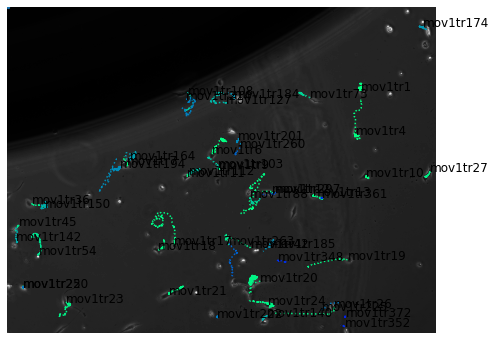

In [ ]:
# %%capture
#@markdown Create Tracks Plot
centertype='approximate-medoid' #@param {"type":string}["centroid", "approximate-medoid"]
# variable_name = "a" #@param ["a", "b"]

def trackqc(ind,show_names,show_paths):
  frame=frames[ind]
  ax_image.imshow(combineds[ind]); #annotated
  # print(show_names);
  if (show_names != names[0].get_visible()):
    for n in names:
      n.set_visible(show_names);
  if (show_paths != paths[0].get_visible()):
    for p in paths:
      p.set_visible(show_paths);
  
  centers=sample_cells_metrics[(sample_cells_metrics['movie'] == movie_microscope) & (sample_cells_metrics['frame']==frame)][[centertype+'x',centertype+'y']]
  
  mask_centers.set_offsets(centers)
  #mask_largecircles.set_offsets(largecircles)
  # set colors
  #scat.set_array (y)
  fig.suptitle('movie '+str(movie)+', frame '+str(frame),fontsize=16)
  
  fig.canvas.draw()
  display(fig) #use with %matplotlib inline

fig = plt.figure(figsize=(12, 6))
ax_image = fig.add_subplot(111) 

l=ax_image.imshow(combineds[0],cmap="gray")
mask_centers=ax_image.scatter(1,1,s=20,marker='.')
#mask_largecircles=ax_image.scatter(1,1,color='blue',s=2)

imov=movie-1
movieaut=sample[imov]
     
paths = [];
names = [];

for itr in progress_bar(range(len(movieaut))):
  if len(sampTrStatus[imov]) > 0:
    colorsaut = [cm.winter(i) for i in np.linspace(1, 0, len(sampTrStatus[imov]))]
    if sampTrStatus[imov][itr]==1:
        paths += ax_image.plot(movieaut[itr][centertype+'x'], movieaut[itr][centertype+'y'], color=colorsaut[itr],linestyle='dotted')
        names.append(ax_image.text(movieaut[itr][centertype+'x'].iloc[0], movieaut[itr][centertype+'y'].iloc[0],'mov'+str(imov+1)+'tr'+str(itr+1),fontsize=12))

ax_image.axis('off')

In [ ]:
interact(trackqc, ind=widgets.IntSlider(min=0,max=len(frames)-1,step=1,value=0,layout=Layout(width='50%', height='40px')),show_names=False,show_paths=False) 

interactive(children=(IntSlider(value=0, description='ind', layout=Layout(height='40px', width='50%'), max=282…

<function __main__.trackqc>

In [ ]:
#@markdown ##Play movie
import time
import ipywidgets
#@markdown how quickly movie will be shown in frames per second (will be limited by image display speed)
framerate =  0.5#@param {"type":"number"}
delay = 1/framerate;





play = widgets.Play(
    value=0,
    min=0,
    max=len(frames)-1,
    step=1,
    interval=delay*1000,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider(msg_throttle=1)
widgets.jslink((play, 'value'), (slider, 'value'))
# display(widgets.HBox([play, slider]))
display(play);
interact(trackqc,ind=slider,show_names=False,show_paths=False);


Play(value=0, description='Press play', interval=2000, max=282)

interactive(children=(IntSlider(value=0, description='ind'), Checkbox(value=True, description='show_names'), C…

## Save tracking QC output 

### Save trackQC data in output folder in GCP bucket

In [ ]:
qc_output={'tracks_status':sampTrStatus, 'minTrackLength':minTrackLength,'keep':keep,
                   'trim':trim, 'removemov':removemov, 'exclude':exclude}

with open(local_analysis_output_folder/'qc_output.pkl', 'wb') as handle:
    pickle.dump(qc_output, handle)

push_analysis();

Copying file:///content/2022.2.7_Random_Migration_qc_output.pkl [Content-Type=application/octet-stream]...
/ [1 files][  5.9 KiB/  5.9 KiB]                                                
Operation completed over 1 objects/5.9 KiB.                                      


### Save tracks after quality control saving gel region as a feature

####Get data

In [ ]:
folder_output = ntpath.basename(output_path)

In [ ]:
#Get trackQC operations from GCP bucket
!gsutil cp gs://{output_path}/{experiment}_qc_output.pkl ./  

with open(experiment+'_qc_output.pkl', 'rb') as handle:
            qc_output = pickle.load(handle, encoding='latin1')


#read preQC tracks from folder_output in GCP bucket

!gsutil cp gs://{output_path}/{experiment}_tracks.pkl ./  

with open(experiment+'_tracks.pkl', 'rb') as handle:
            tracks = pickle.load(handle, encoding='latin1')

Copying gs://cellmbucket/analysis_eliz_Control-sets-NEW/JR20scrambletrial2_qc_output.pkl...
/ [1 files][  3.2 KiB/  3.2 KiB]                                                
Operation completed over 1 objects/3.2 KiB.                                      
Copying gs://cellmbucket/analysis_eliz_Control-sets-NEW/JR20scrambletrial2_tracks.pkl...
/ [1 files][905.5 KiB/905.5 KiB]                                                
Operation completed over 1 objects/905.5 KiB.                                    


In [ ]:
qc_output

{'exclude': [[1, 24],
  [8, 16],
  [10, 29],
  [11, 11],
  [12, 1],
  [13, 1],
  [21, 9],
  [24, 1],
  [26, 35]],
 'keep': [[2, 1],
  [3, 26],
  [4, 1, 21],
  [5, 1, 20],
  [6, 18],
  [7, 1, 15],
  [14, 15],
  [15, 21, 22],
  [16, 1, 9],
  [17, 1, 65],
  [18, 1, 15, 73, 69],
  [19, 13],
  [25, 17],
  [27, 7],
  [28, 1],
  [29, 4],
  [31, 3, 15],
  [32, 1],
  [37, 3, 6]],
 'minTrackLength': 10,
 'removemov': [34, 35, 36, 38],
 'tracks_status': [[1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   

In [ ]:
#apply quality control operations on tracks
sampTrStatus, tracksqc = apply_qc(tracks, qc_output['minTrackLength'], qc_output['keep'],
                                qc_output['trim'], qc_output['removemov'],
                                qc_output['exclude'])

#### Read gel regions from text file (old control sets)

In [ ]:
regions_path = maskspath[:-4] + '-regions.txt'
!gsutil cp gs://{regions_path} ./

CommandException: No URLs matched: gs://cellmbucket/Control-sets-NEW/1082021_trial2-cell-masks-regions.txt


In [ ]:
#Read regions
regions_obj = open(ntpath.basename(regions_path), "r")
regions = regions_obj.readlines()
#Get regions and movie number in separate lists
regions_list= [re.findall(r"_(.+)\.",regions[i])[0] for i in range(len(regions))]
movies_list = [re.findall(r"(\d+)_",regions[i])[0] for i in range(len(regions))]
#remove spaces
regions_list= [regions_list[i].replace(" ","") for i in range(len(regions_list))]

#Make dataframe
regions_movie_df =pd.DataFrame({"region":regions_list, "movie":movies_list})

In [ ]:
#Define function to map from movie to region
def movie2region(movie):
  #get region for particular movie
  region = regions_movie_df["region"][ regions_movie_df["movie"]==str(movie) ]
  #Get plain string
  region = list(region)[0]

  return region

In [ ]:
#different names were used for same gel region, therefore
#function to map from region to stdregion
def stdregfun(f):
  #if ( f.endswith('steep1') or f.endswith('steepz1') or  f.endswith('line')  or f.endswith('lineorsteepz1') or f.endswith('Lineorsteepz1') or f.endswith('Lineofsteepz1') or  f.endswith('lineorsteepzone1')  ):
  if ( f.endswith('steep1') or f.endswith('steepz1') or  f.endswith('line')  or  f.endswith('lineorsteepzone1')  ):
    stdregion = 'gradient1'
  elif ( f.endswith('steep2') or f.endswith('steepz2') ):
    stdregion = 'gradient2'
  elif ( f.endswith('stiff') ):
    stdregion = 'stiff'
  elif ( f.endswith('soft') ):
    stdregion = 'soft'
  else:
    stdregion = 'error'
    sys.exit(0)
  return stdregion



#### Read gel regions from text file (new datasets: Arpc2, Fascin)

In [ ]:
#Get gel regions .txt file from GCP bucket
regions_path = ntpath.dirname(maskspath) + '/' + ntpath.basename(imagespath) + '_info.txt'
!gsutil cp gs://{regions_path} /content

Copying gs://cellmbucket/Control-sets-NEW/JR20scrambletrial2_info.txt...
/ [1 files][  190.0 B/  190.0 B]                                                
Operation completed over 1 objects/190.0 B.                                      


In [ ]:
#Get ordered list of regions as they correspond to movie number
regions_obj = open(ntpath.basename(regions_path), "r")
lines_to_list = regions_obj.readlines()
regions = ['stiff', 'steep1', 'steep2', 'soft','line']
moviesregions = {}

for word in regions:
  for count, line in enumerate(lines_to_list):
    if word in line:
      split = line.split('-')
      mov_num = int(split[1].strip('/n'))
      moviesregions[mov_num]=word

In [ ]:
#Read regions
regions_list = []
clean_num_old = 0

for obj in sorted(moviesregions.items()):
  word = obj[1]
  for line in lines_to_list:
    if word in line:
      split = line.split('-')
      clean_num = int(split[1].strip('/n'))
      diff = clean_num - clean_num_old
      clean_num_old = clean_num
      repeat = [word] * diff
      regions_list.extend(repeat)

movies_list = [*range(1, int(clean_num)+1, 1)]

#Make dataframe
regions_movie_df =pd.DataFrame({"region":regions_list, "movie":movies_list})

In [ ]:
#Define function to map from movie to region
def movie2region(movie):
  #get region for particular movie
  region = regions_movie_df["region"][ regions_movie_df["movie"]==movie ]
  #Get plain string
  region = list(region)[0]

  return region

In [ ]:
#different names were used for same gel region, therefore
#function to map from region to stdregion
def stdregfun(f):
  #if ( f.endswith('steep1') or f.endswith('steepz1') or  f.endswith('line')  or f.endswith('lineorsteepz1') or f.endswith('Lineorsteepz1') or f.endswith('Lineofsteepz1') or  f.endswith('lineorsteepzone1')  ):
  if ( f.endswith('steep1') or f.endswith('steepz1')   ):
    stdregion = 'gradient1'
  elif ( f.endswith('steep2') or f.endswith('steepz2') ):
    stdregion = 'gradient2'
  elif ( f.endswith('line')  ):
    stdregion = 'line'
  elif ( f.endswith('stiff') ):
    stdregion = 'stiff'
  elif ( f.endswith('soft') ):
    stdregion = 'soft'
  else:
    stdregion = 'error'
    sys.exit(0)
  return stdregion



#### Read gel regions from text file (new NEW datasets: control-sets-NEW)

In [ ]:
#Get gel regions .txt file from GCP bucket
regions_path = ntpath.dirname(maskspath) + '/' + ntpath.basename(imagespath) + '_info.txt'
!gsutil cp gs://{regions_path} /content

Copying gs://cellmbucket/Control-sets-NEW/JR20scrambletrial2_info.txt...
/ [1 files][  190.0 B/  190.0 B]                                                
Operation completed over 1 objects/190.0 B.                                      


In [ ]:
#Get ordered list of regions as they correspond to movie number
regions_obj = open(ntpath.basename(regions_path), "r")
lines_to_list = regions_obj.readlines()
regions = ['stiff', 'steepz1', 'steepz2', 'soft', 'line', 'steep1', 'steep2']
moviesregions = {}

for word in regions:
  for count, line in enumerate(lines_to_list):
    if word in line:
      split = line.split('-')
      mov_num = int(split[1].strip('/n'))
      moviesregions[mov_num]=word

In [ ]:
#Read regions
regions_list = []
clean_num_old = 0

for obj in sorted(moviesregions.items()):
  word = obj[1]
  for line in lines_to_list:
    if word in line:
      split = line.split('-')
      clean_num = int(split[1].strip('/n'))
      diff = clean_num - clean_num_old
      clean_num_old = clean_num
      repeat = [word] * diff
      regions_list.extend(repeat)

movies_list = [*range(1, int(clean_num)+1, 1)]

#Make dataframe
regions_movie_df =pd.DataFrame({"region":regions_list, "movie":movies_list})

In [ ]:
#Define function to map from movie to region
def movie2region(movie):
  #get region for particular movie
  region = regions_movie_df["region"][ regions_movie_df["movie"]==movie ]
  #Get plain string
  region = list(region)[0]

  return region

In [ ]:
#different names were used for same gel region, therefore
#function to map from region to stdregion
def stdregfun(f):
  #if ( f.endswith('steep1') or f.endswith('steepz1') or  f.endswith('line')  or f.endswith('lineorsteepz1') or f.endswith('Lineorsteepz1') or f.endswith('Lineofsteepz1') or  f.endswith('lineorsteepzone1')  ):
  if ( f.endswith('steep1') or f.endswith('steepz1')   ):
    stdregion = 'newsteep'
  elif ( f.endswith('steep2') or f.endswith('steepz2') ):
    stdregion = 'gradient2'
  elif ( f.endswith('line')  ):
    stdregion = 'line'
  elif ( f.endswith('stiff') ):
    stdregion = 'stiff'
  elif ( f.endswith('soft') ):
    stdregion = 'soft'
  else:
    stdregion = 'error'
    sys.exit(0)
  return stdregion



#### Add region as a feature to quality controlled tracks and save

In [ ]:
tracksreg=[]
for imov in range(len(tracksqc)):
  for itr in range(len(tracksqc[imov])):
    #if the track satus == 1 (track passed QC)
    if sampTrStatus[imov][itr]==1:
      movie=int(tracksqc[imov][itr]['movie'].iloc[0])
      region = movie2region(movie)
      stdregion = stdregfun(region)
      #add std region name as feature
      tracksqc[imov][itr]['gel-region'] = stdregion
      tracksreg.append(tracksqc[imov][itr])

In [ ]:
with open(experiment+'_tracksqc.pkl', 'wb') as handle:
       pickle.dump(tracksreg, handle, protocol=2)

!gsutil cp {experiment}_tracksqc.pkl gs://{output_path}

Copying file://JR20scrambletrial2_tracksqc.pkl [Content-Type=application/octet-stream]...
/ [1 files][118.4 KiB/118.4 KiB]                                                
Operation completed over 1 objects/118.4 KiB.                                    


In [ ]:
#grouped_tracks[0]
len(tracksreg)

53

In [ ]:
#Count total tracks from ungrouped tracks
tot_tracks=0
for imov in range(len(tracksqc)):
  tot_tracks += np.sum(sampTrStatus[imov]) #tracks after quality control
  #tot_tracks +=1 #all raw tracks before quality control
tot_tracks

43